<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Predict_fake_news_using_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Detect fake news from news articles using machine learning models.

In [1]:
# Import the software libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [26]:
# Load the data into Colab.
from google.colab import files # Use to load data on Google Colab
uploaded = files.upload()      # Use to load data on Google Colab

Saving news.csv to news.csv


In [3]:
#Store the data into a data frame. 
news = pd.read_csv('news.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Filter the data set and rename some columns. 
news = news[['Unnamed: 0', 'title', 'text', 'label']].copy()
news.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
news.rename(columns = {'label':'news_type'}, inplace = True)

In [5]:
# Print the first 5 rows of the dataset.
news.head() 

,ID,title,text,news_type
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


This data came from Kaggle's website. The data can be found here https://www.kaggle.com/shubh0799/fake-news

The columns and definitions are listed below.

1. ID - news identifier. 

2. title - title of the article.

3. text - text of the article. 

4. news_type - type of news ("FAKE" or "REAL"). 

In [6]:
# Show information about the data columns.
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7795 entries, 0 to 7794
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         7576 non-null   object
 1   title      7185 non-null   object
 2   text       6929 non-null   object
 3   news_type  6755 non-null   object
dtypes: object(4)
memory usage: 243.7+ KB


There are 7,795 articles and 4 columns. All the variables are alpha-numeric and contain null or missing values.  

In [7]:
# Filter data frame to only include rows with news type of real or fake. 
options = ['REAL', 'FAKE'] 
    
# Select rows based on news type.
news = news.loc[news['news_type'].isin(options)] 

In [8]:
# Show news types and counts for each type. 
news['news_type'].value_counts()

REAL    3161
FAKE    3154
Name: news_type, dtype: int64

Text(0, 0.5, 'News Type')

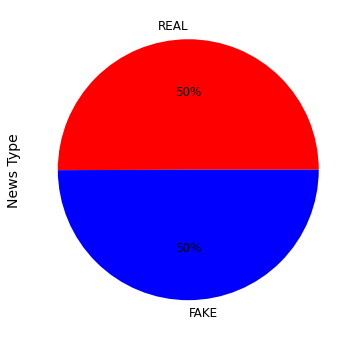

In [9]:
# Visualize the distribution of news types.
news.news_type.value_counts().plot(kind='pie', autopct='%1.0f%%',  fontsize=12, figsize=(9,6), colors=["red", "blue"])
plt.ylabel('News Type', size=14)

The news articles are equally distributed between real news and fake news. 

**Data Cleaning**

We need to divide our dataset into feature and label data sets. The features data set will include only the news articles text which is in the 3rd column or index 2. The labels data set will include the articles news type that we want to predict in column 4 or index 3. We will use the iloc method on the news data frame to create the features and labels data sets.

In [10]:
# Divide our dataset into feature and label data sets.
# Feature data set will include only the news articles text which is in the 3rd column or index 2.
# Label data set will include the articles news type that we want to predict in column 4 or index 3.
features = news.iloc[:, 2].values
labels = news.iloc[:, 3].values

Split the Data into Training and Test Data Sets

In [11]:
# Use train_test_split function to generate training data and test data. Test data set will be 20% of the original data set.
# Training data will be used to train the model. Test data will be used to evaluate the performance of the model. 

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(news['text'], labels, test_size=0.2, random_state=7)

**Converting Text to Numbers**

Statistical algorithms use mathematics to train machine learning models and  mathematics only works with numbers. Therefor, to make statistical algorithms work with text, we need to convert the text into numbers. To accomplish this we will use TF-IDF which stands for Term Frequency — Inverse Document Frequency. The idea behind the TF-IDF approach is that the words that occur less in all the articles and more in an individual article contribute more towards classification. The TF-IDF is a score which is applied to every word in every  article in our dataset. And for every word, the TF-IDF value increases with every appearance of the word in a article, but will gradually decrease with every appearance in other articles.

TF and IDF are calculated as follows:

*   TF  = (Frequency of a word in the document)/(Total words in the document)
*   IDF = Log((Total number of docs)/(Number of docs containing the word))


If you would like to learn more about TF-IDF, visit this site: https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275


We will use Python's Scikit-Learn library which contains the TfidfVectorizer class that will be used to convert text features into TF-IDF feature vectors.

In [12]:
# Use TfidfVectorizer to convert text features into TF-IDF feature vectors.
# max_df includes words that occur in a maximum of 70% of the news articles.
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer (stop_words=('english'), max_df=0.7)

# Fit and transform training and test data sets.
tfidf_train = vectorizer.fit_transform((x_training_data).astype('U'))
tfidf_test = vectorizer.transform(x_test_data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



* max_df is set to 0.7 which specifies to only use those words that occur in a maximum of 70% of the news articles. Words that occur in all news articles are not useful for classification.




**We will now train models, make predictions and evaluate the performance of four different models.**

**Passive Aggressive Classifier**

In [13]:
# Create model object.
pa = PassiveAggressiveClassifier(max_iter=50)
# Train the model on the training data.
pa.fit(tfidf_train, y_training_data) 
# Make predictions on the test data. 
predictions_pa = pa.predict(tfidf_test)

In [14]:
# Calculate the Accuracy Score.
pa = accuracy_score(y_test_data, predictions_pa)
print(f'Accuracy: {round(pa*100,2)}%')

Accuracy: 92.56%


In [15]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_pa))

              precision    recall  f1-score   support

        FAKE       0.91      0.94      0.93       620
        REAL       0.94      0.91      0.93       643

    accuracy                           0.93      1263
   macro avg       0.93      0.93      0.93      1263
weighted avg       0.93      0.93      0.93      1263



The passive aggressive classifier model accurately predicted 93% of the news articles as being fake or real. 

*  91% correctly predicted fake news.
*  94% correctly predicted real news. 

**Logistic Regression Model**

In [16]:
# Create model object. 
model_lr = LogisticRegression(max_iter=150)
# Train the model on the training data.
model_lr.fit(tfidf_train, y_training_data)
# Make predictions on the test data. 
predictions_lr = model_lr.predict(tfidf_test)

In [17]:
# Calculate the Accuracy Score.
lr = accuracy_score(y_test_data, predictions_lr)
print(f'Accuracy: {round(lr*100,2)}%')

Accuracy: 90.42%


In [18]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_lr))

              precision    recall  f1-score   support

        FAKE       0.87      0.94      0.91       620
        REAL       0.94      0.87      0.90       643

    accuracy                           0.90      1263
   macro avg       0.91      0.90      0.90      1263
weighted avg       0.91      0.90      0.90      1263



The logistic regression model accurately predicted 90% of the news articles as being fake or real. 

*  87% correctly predicted fake news.
*  94% correctly predicted real news. 

**Support Vector Machine Model**

In [19]:
# Create model object. 
model_sv = SVC()
# Train the model on the training data.
model_sv.fit(tfidf_train, y_training_data)
# Make predictions on the test data. 
predictions_sv = model_sv.predict(tfidf_test)

In [20]:
# Calculate the Accuracy Score.
sv = accuracy_score(y_test_data, predictions_sv)
print(f'Accuracy: {round(sv*100,2)}%')

Accuracy: 91.37%


In [21]:
# Show the classification report. 
print(classification_report(y_test_data, predictions_sv))

              precision    recall  f1-score   support

        FAKE       0.88      0.95      0.92       620
        REAL       0.95      0.88      0.91       643

    accuracy                           0.91      1263
   macro avg       0.92      0.91      0.91      1263
weighted avg       0.92      0.91      0.91      1263



The support vector machine model accurately predicted 91% of the news articles as being fake or real. 

*  88% correctly predicted fake news.
*  95% correctly predicted real news. 

**Random Forrest Model**

In [22]:
# Create model object. 
model_rf = RandomForestClassifier(n_estimators = 200, random_state=0)
# Train the model on the training data.
model_rf.fit(tfidf_train, y_training_data)
# Make predictions on the test data. 
predictions_rf = model_rf.predict(tfidf_test)

In [23]:
# Calculate the Accuracy Score.
rf = accuracy_score(y_test_data, predictions_rf)
print(f'Accuracy: {round(rf*100,2)}%')

Accuracy: 90.58%


In [24]:
# Evaluate the performance of the model.  
print(classification_report(y_test_data, predictions_rf))

              precision    recall  f1-score   support

        FAKE       0.89      0.92      0.91       620
        REAL       0.92      0.89      0.91       643

    accuracy                           0.91      1263
   macro avg       0.91      0.91      0.91      1263
weighted avg       0.91      0.91      0.91      1263



The random forrest model accurately predicted 91% of the news articles as being fake or real.  

*   89% correctly predicted fake news.  
*   92% correctly predicted real news. 

,Model,Accuracy_score
0,Passive Aggresive Classifier,0.925574
2,Support Vector Machine,0.913698
3,Random Forrest,0.905780
1,Logistic Regression,0.904196


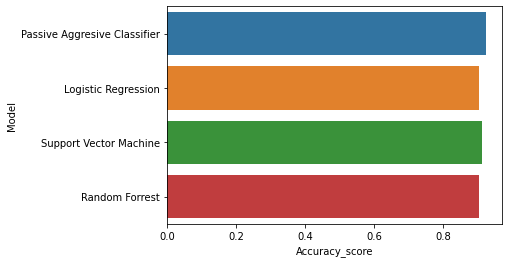

In [25]:
# Show Accuraccy Score by Model.
models = pd.DataFrame({
    'Model':['Passive Aggresive Classifier', 'Logistic Regression', 'Support Vector Machine', 'Random Forrest'],
    'Accuracy_score' :[pa, lr, sv, rf]
})
models
sns.barplot(x='Accuracy_score', y='Model', data=models)

models.sort_values(by='Accuracy_score', ascending=False)


Conclusions: 
The news publication analysis is one of the most commonly performed tasks in Natural Language Processing. This analysis helps determine whether the contents of a news article are real and authentic or fake and misleading.     

The passive aggressive classifier model had the highest accuracy score. This model correctly predicted 93% of the news articles to be fake or real based on the text in the article. This was closely  followed by the  support vector machine model that correctly predicted 91% of the news articles to be fake or real based on the text in the article. Both passive aggressive classifier and support vector machine models were slightly better at predicting real news over fake news.     

The models accuracy may be improved by increasing the number of news articles in the dataset and by tuning some of the models hyper parameters.   